### Convolutional Neural Network

This is a basic convolutional approach to sequence prediction using convolutions through PyTorch!

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os, sys
import pickle

### All at once prediction

In [110]:
# globals
INPUT_STEPS = 24*7 #  1 week
OUTPUT_STEPS = 24   # 1 day

In [111]:
# load data through the data preprocessor
sys.path.append(os.path.abspath('..'))  # add parent directory to sys.path
from data_cleanup import DataProcessor

processor = DataProcessor(input_steps=INPUT_STEPS, output_steps=OUTPUT_STEPS, time_sampling='H') # get 24 hour sequences, and a 1 hour output
Train, Val, Test = processor.load_and_process_data()

X_train, y_train = Train
X_val, y_val = Val
X_test, y_test = Test

print(f"Train: \n \t X: {X_train.shape}, y: {y_train.shape}")
print(f"Val: \n \t X: {X_val.shape}, y: {y_val.shape}")
print(f"Test: \n \t X: {X_test.shape}, y: {y_test.shape}")

Step 1/5: Fetching, cleaning, and engineering features...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/venv/lib/python3.11/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Step 2/5: Resampling data to hourly and setting 'Global_active_power' as target...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:121: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_timesampled = df.resample(self.time_sampling).agg(agg_dict) # 'T' for minute-wise, 'H' for hourly
/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timesampled = df_timesampled.fillna(method='ffill')


Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Processed 50% of data...
Processed 100% of data...
Processed 100% of data...
Processed 100% of data...
Step 5/5: Data processing complete.
Train: 
 	 X: (25736, 168, 8), y: (25736, 24)
Val: 
 	 X: (3433, 168, 8), y: (3433, 24)
Test: 
 	 X: (4847, 168, 8), y: (4847, 24)


In [112]:
print(X_train[0].shape)
print(y_train[0].shape)

(168, 8)
(24,)


In [113]:
# Convolutional Neural Network: 
# The input will be a sequence of 24 hours of data, with 8 features/channels
# Slide a window through the hours and create data for the next layer 

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__() # Inherit from nn.Module
        # Define layers: 3 convolutions (1D) and 2 fully connected layers (very standard)
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=3)  # in_channels = number of features
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3) # out_channels = number of features computed for the next layer to use
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=20, kernel_size=3) # kernel_size = size of the filter/window
        self.pool = nn.MaxPool1d(kernel_size=2) # reusable pool layer

        # auto-detect the flat output dimension
        with torch.no_grad():
            test_input = torch.zeros(1, 8, INPUT_STEPS) # batch size of 1, 8 features, 24 time steps
            out = self.conv1(test_input)
            out = self.conv2(out)
            out = self.conv3(out)
            flat_size = out.view(1, -1).size(1)
            
            print(f"Output shape: {flat_size}")

        self.fc1 = nn.Linear(in_features=flat_size, out_features=256) # here the in_features are 20 but that's just a coincidence, ask chatgpt to compute it for you
        self.fc2 = nn.Linear(in_features=256, out_features=OUTPUT_STEPS)
    
    def forward(self, x): # define how the layers are going to interact
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten the output of the last convolution to be given into a regular linear layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
# --------------------------------------------------
# Residual Block (no stride, same-channel skip)
# --------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=padding)

    def forward(self, x):
        identity = x
        out = self.relu1(self.conv1(x))
        out = self.conv2(out)
        return F.relu(out + identity)   # RESIDUAL SKIP HERE


# --------------------------------------------------
# MAIN CNN MODEL
# --------------------------------------------------
class CNN_V2(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------------------------
        # Feature extractor
        # ---------------------------

        # Block 1 – wide kernels for long context
        self.block1 = nn.Sequential(
            nn.Conv1d(8, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # 168 → 84
        )

        # Block 2 – residual block for deeper structure
        self.block2_prelayer = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   # 84 → 42
        )
        self.resblock = ResidualBlock(64, kernel_size=3)

        # Block 3 – final refinement
        self.block3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # ---------------------------
        # Auto-detect flattened size
        # ---------------------------
        with torch.no_grad():
            x = torch.zeros(1, 8, 168)
            x = self.block1(x)
            x = self.block2_prelayer(x)
            x = self.resblock(x)
            x = self.block3(x)
            flat = x.view(1, -1).size(1)

        # ---------------------------
        # MLP HEAD
        # ---------------------------

        # Apply *only one* BatchNorm right before the MLP
        self.pre_mlp_norm = nn.BatchNorm1d(flat)

        self.fc1 = nn.Linear(flat, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 24)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2_prelayer(x)
        x = self.resblock(x)
        x = self.block3(x)

        x = x.view(x.size(0), -1)

        x = self.pre_mlp_norm(x)     # ONE BatchNorm ahead of MLP

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [115]:
# train
epochs = 20

net = CNN_V2()

# Linear ramp: small at t=0 up to 1 at t=T-1
weights_linear = np.linspace(0.1, 1.0, OUTPUT_STEPS)
# criterion = WeightedMSE(weights_linear)
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# turn data into torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)

# use DataLoader, an iterable object from pytorch, that helps with batch training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # the inputs are given like (batch, time, features),
        # but the model expects (batch, features, time), permutate it: 
        inputs = inputs.permute(0, 2, 1)  

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total += inputs.shape[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [116]:
# convert test data
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# create a test loader
test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_test_t, y_test_t),
    batch_size=4,
    shuffle=False
)

# compute errors
net.eval()
with torch.no_grad():
    train_error = []
    for inputs, labels in train_loader:
        inputs = inputs.permute(0, 2, 1)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        train_error.append(loss.item())

    test_error = []
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_error.append(loss.item())

net.train()  # go back to training mode

print("Train Error: %.3f, Test Error: %.3f" % (np.mean(train_error), np.mean(test_error)))

Train Error: 0.013, Test Error: 0.009


sample shape:  torch.Size([8, 168])
label shape:  torch.Size([24])
prediction shape:  torch.Size([4, 24])


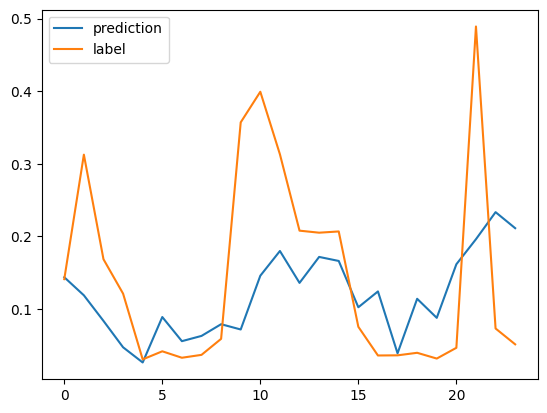

In [122]:
# plot an example: 

# select random datapoint from data loader: 
batch_inputs, batch_labels = next(iter(test_loader))
batch_inputs = batch_inputs.permute(0, 2, 1)

sample = batch_inputs[0]
label = batch_labels[0]

with torch.no_grad():
    prediction = net(batch_inputs)

print("sample shape: ", sample.shape)
print("label shape: ", label.shape)
print("prediction shape: ", prediction.shape)


# # plot the first sequence in the batch: 
plt.plot(prediction[0], label="prediction")
plt.plot(label, label="label")
plt.legend()
plt.show()

In [90]:
## create a 24 hr simulation
## compare last hour prediction with direct 24 hour prediction to reconstruct the sequence!
## compute agregated error (point wise, not area under curve)
## compare previous knowledge needed v/s accuracy: 
##.     means -> repeat the process with 24, 48, 96, 120, 144, 168 hours 
##.     plot losses as well

### Hour by hour prediction

In [91]:
# globals
INPUT_STEPS = 24 #  1 day
OUTPUT_STEPS = 1   # 1 hour

In [92]:
# load data through the data preprocessor
sys.path.append(os.path.abspath('..'))  # add parent directory to sys.path
from data_cleanup import DataProcessor

processor = DataProcessor(input_steps=INPUT_STEPS, output_steps=OUTPUT_STEPS, time_sampling='H', get_all_label_features=True) 
Train, Val, Test = processor.load_and_process_data()

X_train_hourly, y_train_hourly = Train
X_val_hourly, y_val_hourly = Val
X_test_hourly, y_test_hourly = Test

print(f"Train: \n \t X: {X_train_hourly.shape}, y: {y_train_hourly.shape}")
print(f"Val: \n \t X: {X_val_hourly.shape}, y: {y_val_hourly.shape}")
print(f"Test: \n \t X: {X_test_hourly.shape}, y: {y_test_hourly.shape}")

Step 1/5: Fetching, cleaning, and engineering features...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/venv/lib/python3.11/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Step 2/5: Resampling data to hourly and setting 'Global_active_power' as target...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:121: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_timesampled = df.resample(self.time_sampling).agg(agg_dict) # 'T' for minute-wise, 'H' for hourly


Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Processed 100% of data...
Processed 10% of data...
Processed 20% of data...
Processed 30% of data...
Processed 40% of data...
Processed 50% of data...
Processed 60% of data...
Processed 70% of data...
Processed 80% of data...
Processed 90% of data...
Processed 100% of data...
Processed 50% of data...
Processed 100% of data...
Step 5/5: Data processing complete.
Train: 
 	 X: (25903, 24, 8), y: (25903, 1, 8)
Val: 
 	 X: (3600, 24, 8), y: (3600, 1, 8)
Test: 
 	 X: (5014, 24, 8), y: (5014, 1, 8)


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timesampled = df_timesampled.fillna(method='ffill')


In [93]:
# For this net we don't use a flat layer as we wish to yield all the features of the label
# this is a necesary thing to be able to produce a simulation that can run indefinetely

class HourlyCNN(nn.Module): 
    def __init__(self):
        super(HourlyCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=32, kernel_size=6)  
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5) 
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=4) 
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=8, kernel_size=1)
        # Collapse time dimension → exactly 1 step
        self.pool = nn.AdaptiveAvgPool1d(output_size=1)

        # get output shape: 
        with torch.no_grad():
            test_input = torch.randn(1, 8, 24)
            test_output = self.conv1(test_input)
            test_output = self.conv2(test_output)
            test_output = self.conv3(test_output)
            test_output = self.conv4(test_output)
            test_output = self.pool(test_output)
            
            print(test_output.shape) # [1, 8, 1]
    
    def forward(self, x): # define how the layers are going to interact
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        return x

In [94]:
# train
epochs = 20

hourly_net = HourlyCNN()

# Linear ramp: small at t=0 up to 1 at t=T-1
weights_linear = np.linspace(0.1, 1.0, OUTPUT_STEPS)
# criterion = WeightedMSE(weights_linear)
criterion = nn.MSELoss()

optimizer = optim.SGD(hourly_net.parameters(), lr=0.001, momentum=0.9)

# turn data into torch tensors
X_train_hourly_t = torch.tensor(X_train_hourly, dtype=torch.float32)
y_train_hourly_t = torch.tensor(y_train_hourly, dtype=torch.float32)
train_dataset = torch.utils.data.TensorDataset(X_train_hourly_t, y_train_hourly_t)

# use DataLoader, an iterable object from pytorch, that helps with batch training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # the inputs are given like (batch, time, features),
        # but the model expects (batch, features, time), permutate them: 
        inputs = inputs.permute(0, 2, 1)  
        labels = labels.permute(0, 2, 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = hourly_net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total += inputs.shape[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

torch.Size([1, 8, 1])
[1,  2000] loss: 0.075
[1,  4000] loss: 0.075
[1,  6000] loss: 0.075
[2,  2000] loss: 0.075
[2,  4000] loss: 0.075
[2,  6000] loss: 0.074
[3,  2000] loss: 0.074
[3,  4000] loss: 0.075
[3,  6000] loss: 0.074
[4,  2000] loss: 0.074
[4,  4000] loss: 0.075
[4,  6000] loss: 0.074
[5,  2000] loss: 0.074
[5,  4000] loss: 0.073
[5,  6000] loss: 0.071
[6,  2000] loss: 0.071
[6,  4000] loss: 0.072
[6,  6000] loss: 0.071
[7,  2000] loss: 0.071
[7,  4000] loss: 0.071
[7,  6000] loss: 0.071
[8,  2000] loss: 0.070
[8,  4000] loss: 0.071
[8,  6000] loss: 0.071
[9,  2000] loss: 0.071
[9,  4000] loss: 0.071
[9,  6000] loss: 0.071
[10,  2000] loss: 0.071
[10,  4000] loss: 0.071
[10,  6000] loss: 0.071
[11,  2000] loss: 0.071
[11,  4000] loss: 0.071
[11,  6000] loss: 0.070
[12,  2000] loss: 0.070
[12,  4000] loss: 0.071
[12,  6000] loss: 0.071
[13,  2000] loss: 0.070
[13,  4000] loss: 0.070
[13,  6000] loss: 0.071
[14,  2000] loss: 0.070
[14,  4000] loss: 0.070
[14,  6000] loss: 0.0

In [95]:
def sim_hourly(input_steps, output_steps_size, model):
    
    running_input = input_steps.clone()  # shape [8, 24]
    sim_outputs = [] 

    for _ in range(output_steps_size):

        # model expects shape [1, C, T]
        inp = running_input.unsqueeze(0)

        # predict next hour
        output = model(inp).squeeze(0)   # shape [8, 1] or [8] depending on model

        # ensure output is [8, 1]
        if output.ndim == 1:
            output = output.unsqueeze(1)

        sim_outputs.append(output)

        # append new prediction and remove oldest timestep
        running_input = torch.cat([running_input, output], dim=1)[:, 1:]

    # concatenate all simulated timesteps → [8, output_steps_size]
    return torch.cat(sim_outputs, dim=1)

    
# build a cumulative error function
def point_mse_error(y_true, y_pred):
    """
    y_true, y_pred: tensors shaped [channels=8, time]
    Computes MSE only on channel 1.
    """
    diff = y_true[1] - y_pred[1]
    return torch.mean(diff ** 2).item()

In [96]:
# test model:
processor = DataProcessor(input_steps=24, output_steps=24, time_sampling='H', get_all_label_features=True) 
Train, Val, Test = processor.load_and_process_data() 
X_train, y_train = Train
X_val, y_val = Val
X_test, y_test = Test

# convert test data
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# create a test loader
test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(X_test_t, y_test_t),
    batch_size=4,
    shuffle=False
)

Step 1/5: Fetching, cleaning, and engineering features...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/venv/lib/python3.11/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Step 2/5: Resampling data to hourly and setting 'Global_active_power' as target...


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:121: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_timesampled = df.resample(self.time_sampling).agg(agg_dict) # 'T' for minute-wise, 'H' for hourly


Step 3/5: Splitting data and applying scaler...
Step 4/5: Creating time-series windows...
Processed 10% of data...
Processed 20% of data...
Processed 30% of data...
Processed 40% of data...
Processed 50% of data...
Processed 60% of data...
Processed 70% of data...
Processed 80% of data...
Processed 90% of data...
Processed 100% of data...
Processed 100% of data...
Processed 100% of data...
Step 5/5: Data processing complete.


/Users/felipejaracaceres/Documents/UCD/Machine Learning/ECS171G13/data_cleanup.py:122: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_timesampled = df_timesampled.fillna(method='ffill')


In [97]:
# compute errors

total_cumulative_error = 0
hourly_net.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 2, 1)
        labels = labels.permute(0, 2, 1)
        for i in range(len(inputs)):
            sim_result = sim_hourly(inputs[i], 24, hourly_net)
            total_cumulative_error += point_mse_error(sim_result, labels[i])


mean_error = total_cumulative_error / len(test_loader.dataset)
hourly_net.train()  # go back to training mode

print("Cumulative Error: %.3f" % total_cumulative_error)
print("Mean Error: %.3f" % mean_error)


Cumulative Error: 36.260
Mean Error: 0.007


torch.Size([4, 8, 24])
torch.Size([4, 8, 24])
torch.Size([8, 24])


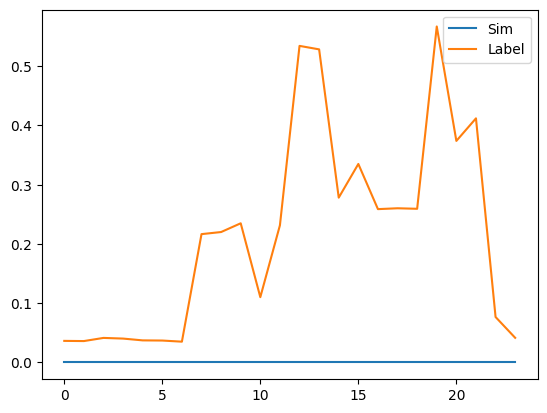

In [98]:
sample_batch_input, sample_batch_label = next(iter(test_loader))
sample_batch_input = sample_batch_input.permute(0, 2, 1)
sample_batch_label = sample_batch_label.permute(0, 2, 1)
print(sample_batch_input.shape)
print(sample_batch_label.shape)

with torch.no_grad():
    sim = sim_hourly(sample_batch_input[0], 24, hourly_net)
# print(sim.shape)
print(sim.shape)

# plt.plot(sample_batch_input[0][1].numpy())
plt.plot(sim[0].numpy(), label="Sim")
plt.plot(sample_batch_label[0][0].numpy(), label="Label")
plt.legend()

